# **1. 프로세스 동작 예측** -> 피드백 반영

**1초 단위의 프로세스 별 플래그 데이터를 이용하여 LSTM 알고리즘으로 향후 프로세스 동작을 예측한다.**

**피드백 내용** - 0~1사이의 값으로 스케일링하고, 활성함수를 sigmoid로 설정하여 학습시켜보기

In [16]:
## 라이브러리 import

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
## 데이터 불러오기

df_orig = pd.read_csv('./Merge_Linear_20200616.csv', error_bad_lines=False,) 
df_orig.head()

,INDEX,DATE,TIME,Interval,Mobile_Controller,Alarm,Game,Music,Note,Training,Video,Home_Controller,AirConditioner,DoorLock,Lamp,TV,Vacuum,Washer
0,1,2020-06-16,4:34:27,16467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2020-06-16,4:34:29,16469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2020-06-16,4:34:30,16470,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2020-06-16,4:34:31,16471,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2020-06-16,4:34:32,16472,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------

## **데이터 확인 및 전처리**

In [18]:
## 필요한 칼럼만 뽑기 -> 인덱스, 알람, 전등, TV

df = df_orig[['INDEX','Alarm','Lamp','TV']]

df.head(30)

,INDEX,Alarm,Lamp,TV
0,1,0.0,NaN,NaN
1,2,0.0,NaN,NaN
2,3,0.0,NaN,NaN
3,4,0.0,NaN,NaN
4,5,0.0,NaN,NaN
5,6,0.0,0.0,0.0
6,7,0.0,0.0,0.0
7,8,0.0,0.0,0.0
8,9,0.0,0.0,0.0
9,10,0.0,0.0,0.0


In [19]:
## NaN 확인
df.isna().head(30)

,INDEX,Alarm,Lamp,TV
0,False,False,True,True
1,False,False,True,True
2,False,False,True,True
3,False,False,True,True
4,False,False,True,True
5,False,False,False,False
6,False,False,False,False
7,False,False,False,False
8,False,False,False,False
9,False,False,False,False


### **+전처리 함수 설명**

**(1초 전 플래그 - NaN - 1초 후 플래그)라 할 때,**


**1 - NaN - 1 인 경우 -> 1로 채우기**

**나머지 -> 0으로 채우기**

In [20]:
## 전처리 함수

def prep(df):
    
    df['Alarm'][0]=0 #시작은 일단 0
    df['Lamp'][0]=0
    df['TV'][0]=0
    
        
    for i in range(1,len(df['INDEX'])):
        df['TV'][0]=0
        
        
        # Alarm
        if pd.isna(df['Alarm'][i])==True:
        
            if (df['Alarm'][i-1]==1)and(df['Alarm'][i+1]==1):
                df['Alarm'][i]=1
            else:
                df['Alarm'][i]=0
            
        # Lamp
        if pd.isna(df['Lamp'][i])==True:
        
            if (df['Lamp'][i-1]==1)and(df['Lamp'][i+1]==1):
                df['Lamp'][i]=1
            else:
                df['Lamp'][i]=0
        
         # TV    
        if pd.isna(df['TV'][i])==True:
        
            if (df['TV'][i-1]==1)and(df['TV'][i+1]==1):
                
                df['TV'][i]=1
            else:
                df['TV'][i]=0
        

    return df
    

In [21]:
len(df['INDEX'])

6051

In [22]:
## 전처리 진행

prep(df)
df.isna().head(30)

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

,INDEX,Alarm,Lamp,TV
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
5,False,False,False,False
6,False,False,False,False
7,False,False,False,False
8,False,False,False,False
9,False,False,False,False


In [23]:
## 학습에 사용할 칼럼 만들기 -> A_L_T

df['A_L_T']='a'

for i in range(len(df['INDEX'])):
    
    df['A_L_T'][i] = str(int(df['Alarm'][i])) + str(int(df['Lamp'][i])) + str(int(df['TV'][i]))
    

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

In [24]:
df.head(50)

,INDEX,Alarm,Lamp,TV,A_L_T
0,1,0.0,0.0,0.0,000
1,2,0.0,0.0,0.0,000
2,3,0.0,0.0,0.0,000
3,4,0.0,0.0,0.0,000
4,5,0.0,0.0,0.0,000
5,6,0.0,0.0,0.0,000
6,7,0.0,0.0,0.0,000
7,8,0.0,0.0,0.0,000
8,9,0.0,0.0,0.0,000
9,10,0.0,0.0,0.0,000


In [25]:
## 10진수로 바꿔서 ALT 칼럼 만들기

df['ALT']='a'

for i in range(len(df['INDEX'])):
    df['ALT'][i] = int(df['A_L_T'][i], 2) #int(이진수,2): string -> 10진수로 변환


/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [26]:
## 잘 됐나 확인 -> csv로 추출

df.to_csv('prop_fin.csv')

In [27]:
## ~3000:학습, 3001~4500: 검증, 4501~5800:테스트로 분리

train = df.loc[:3001, ['ALT']]
val = df.loc[3001:4501, ['ALT']]
test = df.loc[4501:5801, ['ALT']]

In [28]:
## 0~1 사이 값으로 스케일링 하기
## MinMaxScaler 사용 -> 참고: https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test) # train 스케일 할 때 fit 해준 분포 그대로 가져와야 하기 때문에 transform만 해주기

In [31]:
## df로 바꾸기
train = pd.DataFrame(scaled_train, columns=['ALT'], index=train.index)
val = pd.DataFrame(scaled_val, columns=['ALT'], index=val.index)
test= pd.DataFrame(scaled_test, columns=['ALT'], index=test.index)

In [32]:
## window(LSTM 훈련 단위)를 60으로 설정하고 shift()로 window 크기만큼 데이터만 이동 시키기

for s in range(1, 61):
    train['shift_{}'.format(s)] = train['ALT'].shift(s)
    val['shift_{}'.format(s)] = val['ALT'].shift(s)
    test['shift_{}'.format(s)] = test['ALT'].shift(s)

val.head(8)

,ALT,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_51,shift_52,shift_53,shift_54,shift_55,shift_56,shift_57,shift_58,shift_59,shift_60
3001,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3002,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3003,0.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3004,0.0,0.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3005,0.0,0.0,0.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3006,0.0,0.0,0.0,0.0,0.5,0.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3007,0.0,0.0,0.0,0.0,0.0,0.5,0.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
## null값 제거 + X/y 나누기

X_train = train.dropna().drop('ALT', axis=1)
y_train = train.dropna()[['ALT']]
X_val = val.dropna().drop('ALT', axis=1)
y_val = val.dropna()[['ALT']]
X_test = test.dropna().drop('ALT', axis=1)
y_test = test.dropna()[['ALT']]

In [34]:
## 분석할 때 numpy ndarray 써야되니까 values로 바꾸기

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values


In [35]:
## Keras LSTM 이용하려면 3차원 변환 필요 -> (데이터 수, slot 수, feature 수)

## (데이터 수, slot 수) 확인 먼저 해보고
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2942, 60)
(2942, 1)
(1441, 60)
(1441, 1)


In [36]:
## reshape 하기
X_train_t = X_train.reshape(X_train.shape[0], 60, 1)
X_val_t = X_val.reshape(X_val.shape[0], 60, 1)
X_test_t = X_test.reshape(X_test.shape[0], 60, 1)



print(X_train_t.shape)
print(X_test_t.shape)

(2942, 60, 1)
(1241, 60, 1)


-----------



## **학습 수행**

In [37]:
## LSTM 모델 만들기 -> Keras 사용

import keras
from keras.layers import LSTM 
from keras.models import Sequential # 레이어를 선형으로 쌓는 모델
from keras.layers import Dense # 완전 연결 레이어
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 객체 
model.add(LSTM(40, input_shape=(60, 1)))# (slot 수, feature 수) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])  
model.summary() # 모델 내용 확인



#optimizer: 'adam', 'sgd'
#activation: 'sigmoid', 'relu'

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [38]:
## 파라미터 설정&fit

#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=300,
          batch_size=120, verbose=1,validation_data=(X_val_t, y_val))

Train on 2942 samples, validate on 1441 samples
Epoch 1/300
2942/2942 [==============================] - 1s 388us/step - loss: 0.0754 - accuracy: 0.3185 - val_loss: 0.0599 - val_accuracy: 0.3199
Epoch 2/300
2942/2942 [==============================] - 1s 274us/step - loss: 0.0579 - accuracy: 0.3185 - val_loss: 0.0534 - val_accuracy: 0.3199
Epoch 3/300
2942/2942 [==============================] - 1s 289us/step - loss: 0.0474 - accuracy: 0.3185 - val_loss: 0.0408 - val_accuracy: 0.3220
Epoch 4/300
2942/2942 [==============================] - 1s 278us/step - loss: 0.0382 - accuracy: 0.3311 - val_loss: 0.0260 - val_accuracy: 0.3317
Epoch 5/300
2942/2942 [==============================] - 1s 277us/step - loss: 0.0244 - accuracy: 0.3341 - val_loss: 0.0195 - val_accuracy: 0.3324
Epoch 6/300
2942/2942 [==============================] - 1s 279us/step - loss: 0.0214 - accuracy: 0.3348 - val_loss: 0.0189 - val_accuracy: 0.3317
Epoch 7/300
2942/2942 [==============================] - 1s 278us/step

----------

## **예측 수행 및 평가**

In [39]:
y_pred = model.predict(X_test_t, batch_size=120)

y_pred

array([[0.32650763],
       [0.32469743],
       [0.32556003],
       ...,
       [0.1694541 ],
       [0.00854436],
       [0.0028852 ]], dtype=float32)

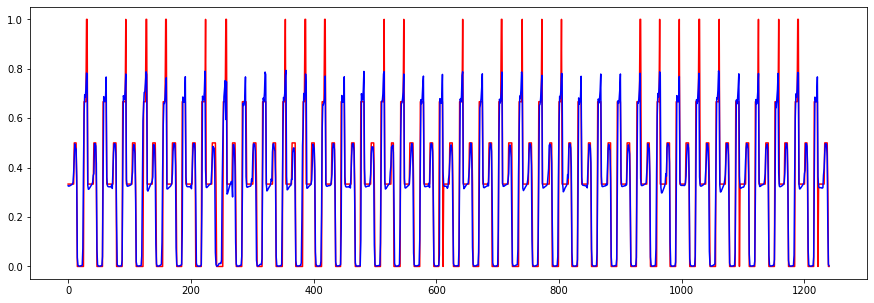

In [40]:
plt.figure(figsize=(15,5))

plt.plot(y_test, color='red', label='true')
plt.plot(y_pred, color='blue', label='pred')

In [41]:
eval_ = model.evaluate(X_test_t, y_test, batch_size=120)
eval_

1241/1241 [==============================] - 0s 73us/step


[0.01052578037460601, 0.3416599631309509]

**결론:** 0.08 -> 0.34로, 활성함수를 sigmoid로 지정했을 때 정확도가 상승하였다.